# Convex Minimization Timing

This notbook is used to time how long it takes to run the solver for the optimization problem, using DCP and DPP.

In [17]:
import numpy as np
import cvxpy as cp
import time

In [18]:
times_dcp = np.zeros(10)
times_dpp = np.zeros(10)

In [105]:
# Setup
ACT_DIM = 10 # action space dimensions
ETA = 1e-8 # used to enforce strict inequality

beta = cp.Parameter() # (> 1) constraint on maximum policy ratio

# safe policy (cvxpy parameters)
mu_safe = cp.Parameter(ACT_DIM)
sigma_safe = cp.Parameter(ACT_DIM, pos=True)

# task policy (cvxpy parameters)
mu_task = cp.Parameter(ACT_DIM)
sigma_task = cp.Parameter(ACT_DIM, pos=True)

# projected policy (cvxpy variables)
mu_proj = cp.Variable(ACT_DIM)
sigma_proj = cp.Variable(ACT_DIM, pos=True)


# Additional variables/parameters for DPP
# safe policy (cvxpy parameters)
sigma_safe_inv = cp.Parameter(ACT_DIM, pos=True) # 1/sigma_safe
sigma_sigma_safe = cp.Parameter(ACT_DIM, pos=True) # sigma_safe^2

# task policy (cvxpy parameters)
sigma_task_inv = cp.Parameter(ACT_DIM, pos=True) # 1/sigma_task
mu_sigma_task = cp.Parameter(ACT_DIM) # mu_task/sigma_task
mu_sigma_sigma_task = cp.Parameter(ACT_DIM)   # mu_task/(sigma_task)^2

# sum term (cvxpy variables)
mu_safe_var = cp.Variable(ACT_DIM)   # mu_safe
sigma_sigma_safe_var = cp.Variable(ACT_DIM, pos=True)   # sigma_safe^2

In [106]:
# Problem definition
objective_dcp = cp.Minimize(-2*cp.sum(cp.log(sigma_proj)) +  cp.sum_squares(sigma_proj/sigma_task) + cp.sum_squares((mu_proj - mu_task)/sigma_task))

constraints_dcp = []

constraint_1_dcp = sigma_proj + ETA <= sigma_safe
constraints_dcp.append(constraint_1_dcp)

sum_term_dcp = 0    # we define the sum term like this so that we can use quad_over_lin and thus allow the problem to be DCP (standard quotient operator is not DCP)
for i in range(0, ACT_DIM):
    sum_term_dcp += cp.quad_over_lin(mu_proj[i] - mu_safe[i],cp.square(sigma_safe[i]) - cp.square(sigma_proj[i]))   # note that numerator gets squared (which we want)

constraint_2_dcp = cp.sum(cp.log(sigma_safe)) - cp.sum(cp.log(sigma_proj)) + (1/2)*sum_term_dcp <= cp.log(beta)
constraints_dcp.append(constraint_2_dcp)

prob_dcp = cp.Problem(objective_dcp, constraints_dcp)

In [107]:
# Problem re-definition as DPP
objective_dpp = cp.Minimize(-2*cp.sum(cp.log(sigma_proj)) +  cp.sum_squares(cp.multiply(sigma_proj,sigma_task_inv)) + cp.sum_squares(cp.multiply(mu_proj,sigma_task_inv)) - 2*cp.sum(cp.multiply(mu_proj, mu_sigma_sigma_task)) + cp.sum_squares(mu_sigma_task))

constraints_dpp = []

constraint_1_dpp = sigma_proj + ETA <= sigma_safe
constraints_dpp.append(constraint_1_dpp)

sum_term_dpp = 0    # we define the sum term like this so that we can use quad_over_lin and thus allow the problem to be DCP (standard quotient operator is not DCP)
for i in range(0, ACT_DIM):
    sum_term_dpp += cp.quad_over_lin(mu_proj[i] - mu_safe_var[i],sigma_sigma_safe_var[i] - cp.square(sigma_proj[i]))   # note that numerator gets squared (which we want)

constraint_2_dpp = -cp.sum(cp.log(sigma_safe_inv)) - cp.sum(cp.log(sigma_proj)) + (1/2)*sum_term_dpp <= cp.log(beta)
constraints_dpp.append(constraint_2_dpp)

constraint_3_dpp = mu_safe_var == mu_safe
constraints_dpp.append(constraint_3_dpp)

constraint_4_dpp = sigma_sigma_safe_var == sigma_sigma_safe
constraints_dpp.append(constraint_4_dpp)

prob_dpp = cp.Problem(objective_dpp, constraints_dpp)

In [108]:
# Generate examples
beta.value = 1.1 # (> 1) constraint on maximum policy ratio

STRAY_FACTOR = 0.05 # factor on how far the task policy strays from the safe policy

N = 1000 # no. examples

mu_safe_list = []
sigma_safe_list = []

mu_task_list = []
sigma_task_list = []

sigma_safe_inv_list = []
sigma_sigma_safe_list = []

sigma_task_inv_list = []
mu_sigma_task_list = []
mu_sigma_sigma_task_list = []

for i in range(0,N):
    # safe policy
    mu_safe_list.append(np.random.randn(ACT_DIM))
    sigma_safe_list.append(np.random.rayleigh(scale=0.5,size=ACT_DIM)) # > 0

    # task policy
    mu_task_list.append(mu_safe_list[i] + STRAY_FACTOR*np.random.randn(ACT_DIM)) # put task policy mean somewhere fairly close to safe policy mean
    sigma_task_list.append(sigma_safe_list[i] - np.minimum(STRAY_FACTOR*sigma_safe_list[i]*np.random.rayleigh(scale=0.5,size=ACT_DIM),sigma_safe_list[i]-ETA))  # put task policy stdev somewhere fairly close to but less than safe policy stdev (and > 0)

    # Set additional DPP parameters for examples

    sigma_safe_inv_list.append(1/sigma_safe_list[i]) # 1/sigma_safe
    sigma_sigma_safe_list.append(np.square(sigma_safe_list[i])) # sigma_safe^2

    # task policy (cvxpy parameters)
    sigma_task_inv_list.append(1/sigma_task_list[i]) # 1/sigma_task
    mu_sigma_task_list.append(mu_task_list[i]/sigma_task_list[i]) # mu_task/sigma_task
    mu_sigma_sigma_task_list.append(mu_task_list[i]/np.square(sigma_task_list[i]))   # mu_task/(sigma_task)^2

In [109]:
# Time DCP

t0_dcp = time.time()
for i in range(0,N):
    mu_safe.value = mu_safe_list[i]
    sigma_safe.value = sigma_safe_list[i]

    mu_task.value = mu_task_list[i]
    sigma_task.value = sigma_task_list[i]

    sigma_safe_inv.value = sigma_safe_inv_list[i]
    sigma_sigma_safe.value = sigma_sigma_safe_list[i]

    sigma_task_inv.value = sigma_task_inv_list[i]
    mu_sigma_task.value = mu_sigma_task_list[i]
    mu_sigma_sigma_task.value = mu_sigma_sigma_task_list[i]

    # warm start as safe policy
    # bad idea since sigma_proj = sigma_safe messes things up
    # mu_proj.value = mu_safe_list[i]
    # sigma_proj.value = sigma_safe_list[i]
    # mu_safe_var.value = mu_safe_list[i]
    # sigma_sigma_safe_var.value = np.square(sigma_safe_list[i])

    result = prob_dcp.solve()
    # result = prob_dcp.solve(warm_start=True)
t1_dcp = time.time()

time_avg_dcp = (t1_dcp - t0_dcp)/N
print((time_avg_dcp))

times_dcp[ACT_DIM-1] = time_avg_dcp
# times_dcp = np.append(times_dcp,time_avg_dcp)

/home/jacques/miniconda3/envs/cvxpy_env/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:237: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


0.035763978242874146


In [110]:
# Time DPP

t0_dpp = time.time()
for i in range(0,N):
    mu_safe.value = mu_safe_list[i]
    sigma_safe.value = sigma_safe_list[i]

    mu_task.value = mu_task_list[i]
    sigma_task.value = sigma_task_list[i]

    sigma_safe_inv.value = sigma_safe_inv_list[i]
    sigma_sigma_safe.value = sigma_sigma_safe_list[i]

    sigma_task_inv.value = sigma_task_inv_list[i]
    mu_sigma_task.value = mu_sigma_task_list[i]
    mu_sigma_sigma_task.value = mu_sigma_sigma_task_list[i]

    # warm start as safe policy
    # bad idea since sigma_proj = sigma_safe messes things up
    # mu_proj.value = mu_safe_list[i]
    # sigma_proj.value = sigma_safe_list[i]
    # mu_safe_var.value = mu_safe_list[i]
    # sigma_sigma_safe_var.value = np.square(sigma_safe_list[i])

    result = prob_dpp.solve()
    # result = prob_dpp.solve(warm_start=True)
t1_dpp = time.time()

time_avg_dpp = (t1_dpp - t0_dpp)/N
print((time_avg_dpp))

times_dpp[ACT_DIM-1] = time_avg_dpp
# times_dpp = np.append(times_dpp,time_avg_dpp)

0.0031546132564544676


In [69]:
import matplotlib.pyplot as plt

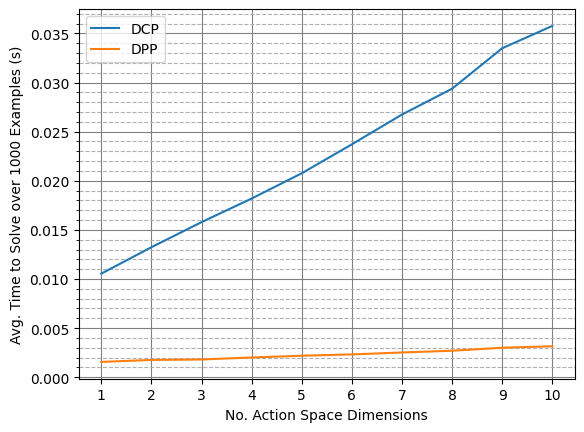

In [113]:
n = np.arange(1,11)
plt.minorticks_on()
plt.plot(n, times_dcp, label="DCP")
plt.plot(n, times_dpp, label="DPP")
plt.legend()
plt.xlabel("No. Action Space Dimensions")
plt.ylabel("Avg. Time to Solve over 1000 Examples (s)")
plt.grid(which="minor", axis="y", linestyle="--")
plt.grid(which="major", linestyle="-", color="gray")
plt.xticks(np.arange(min(n), max(n)+1, 1.0))
plt.tick_params(which='minor', bottom=False)
plt.show()

In [117]:
# Check solutions are still sensible for high no. action space dimensions
print(mu_safe.value)
print(mu_proj.value)
print(mu_task.value)

print(sigma_safe.value)
print(sigma_proj.value)
print(sigma_task.value)

[-1.34393298 -0.42234902 -0.12819579  0.40647794  0.45558529  1.30151
 -0.25131662 -0.75443852  0.35279752  0.9131592 ]
[-1.34393294 -0.43038593 -0.12819582  0.40647795  0.45558528  1.30436552
 -0.25321511 -0.77792684  0.35279768  0.9131592 ]
[-1.30487541 -0.45787663 -0.17600904  0.44467768  0.43306094  1.31561478
 -0.30724842 -0.86411184  0.44907718  0.91729752]
[0.43161192 0.21678157 0.92133534 1.00301918 0.87074775 0.4132179
 0.54146139 0.63938115 0.81946146 0.40391459]
[0.43161189 0.2123759  0.9213353  1.00301916 0.87074771 0.40660868
 0.54015615 0.62710255 0.81946137 0.40391457]
[0.42108628 0.20954204 0.88873709 0.98863082 0.83572374 0.3807335
 0.52229667 0.62241088 0.80841563 0.39658897]
